In [63]:
import sys
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections



## load data
some preprocessing

In [2]:
data_dir = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/tstoy04"

In [3]:
twd_tree_series = pd.read_csv(os.path.join(data_dir, "tstoy04_series.csv"), sep = ",")
twd_tree_sites = pd.read_csv(os.path.join(data_dir, "tstoy04_sites.csv"), sep = ",")


In [4]:
series_file_path = glob.glob(os.path.join(data_dir, "SeparateSeries/tstoy04_*.csv"))
series_name = [os.path.basename(series).replace(".csv", "").replace("tstoy04_", "")for series in series_file_path]
series_file_dfs = {series_name[i]: pd.read_csv(series_file_path[i], sep=",") for i in range(len(series_file_path))}

In [5]:
twd_tree_series["series_no"] = twd_tree_series.index+ 1
twd_tree_series_sites = twd_tree_series.merge(twd_tree_sites, left_on="site", 
                                              right_on = "site_name", how="left")
twd_tree_series_sites["species_site"] = twd_tree_series_sites["species"] + "_" + twd_tree_series_sites["site_name"]

In [6]:
twd_tree_series_sites.head()

,series,species,site,series_no,site_name,site_longitude,site_latitude,site_easting,site_northing,mch_ind_closest,mch_easting,mch_northing,mch_elevation,mch_site_eucldist,species_site
0,19,Fagus sylvatica,Bachtel-Forest,1,Bachtel-Forest,8.89016,47.29413,2.709787e+06,1.239153e+06,46975,2.710088e+06,1.239223e+06,882.140575,308.935980,Fagus sylvatica_Bachtel-Forest
1,120,Quercus petraea,Bueren-Forest,2,Bueren-Forest,7.67722,47.46111,2.617991e+06,1.256731e+06,28625,2.618033e+06,1.256244e+06,537.765575,488.442974,Quercus petraea_Bueren-Forest
2,121,Quercus petraea,Bueren-Forest,3,Bueren-Forest,7.67722,47.46111,2.617991e+06,1.256731e+06,28625,2.618033e+06,1.256244e+06,537.765575,488.442974,Quercus petraea_Bueren-Forest
3,136,Carpinus betulus,Bursins-Forest,4,Bursins-Forest,6.28370,46.45552,2.511271e+06,1.145564e+06,6353,2.511187e+06,1.145981e+06,643.515575,425.379683,Carpinus betulus_Bursins-Forest
4,137,Carpinus betulus,Bursins-Forest,5,Bursins-Forest,6.28370,46.45552,2.511271e+06,1.145564e+06,6353,2.511187e+06,1.145981e+06,643.515575,425.379683,Carpinus betulus_Bursins-Forest


In [30]:
series_file_dfs =collections.OrderedDict(sorted(series_file_dfs.items()))
series_file_dfs_all_info = []
for i, df in enumerate(series_file_dfs.values()):
    df = df.sort_values(by = "ts", ascending= True)
    df['series'] = series_name[i]
    df['site_name'] = twd_tree_series_sites.loc[twd_tree_series_sites['series_no'] == i+1, 'site_name'].values[0]
    df['species'] = twd_tree_series_sites.loc[twd_tree_series_sites['series_no'] == i+1, 'species'].values[0]
    df["series_no"] = i+1
    # calculate Yt-Yt-1
    df["Wt"] = df["twd"].diff()
    series_file_dfs_all_info.append(df)

df_series_all = pd.concat(series_file_dfs_all_info, ignore_index=True )

In [32]:
# split year month and store them in separate columns
df_series_all["year"] = df_series_all["ts"].apply(lambda x: int(x.split("-")[0]))
df_series_all["month"] = df_series_all["ts"].apply(lambda x: int(x.split("-")[1]))
df_series_all["year_month"] = df_series_all["year"].astype(str) + "-" + df_series_all["month"].astype(str).str.zfill(2)



In [33]:
df_series_all.head()

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


* ts = daily time stamp, from 2020-01-01 till 2022-12-31
* twd = target TWD_norm variable, unprocessed
* pr = precipitation in kg/m^2
* at = air temperature in °C
* ws = wind speed in m/S
* dp = dew point in °C
* sr = net short wave radiation flux in W/m^2
* lr = net long wave radiation flux in W/m^2

## plot site maps

In [10]:
twd_tree_series

,series,species,site,series_no
0,19,Fagus sylvatica,Bachtel-Forest,1
1,120,Quercus petraea,Bueren-Forest,2
2,121,Quercus petraea,Bueren-Forest,3
3,136,Carpinus betulus,Bursins-Forest,4
4,137,Carpinus betulus,Bursins-Forest,5
5,138,Carpinus betulus,Bursins-Forest,6
6,139,Carpinus betulus,Bursins-Forest,7
7,193,Corylus avellana,Choeliacher-Orchard,8
8,194,Corylus avellana,Choeliacher-Orchard,9
9,288,Picea abies,Davos-Seehornwald,10


In [11]:
twd_tree_series_sites.head()

,series,species,site,series_no,site_name,site_longitude,site_latitude,site_easting,site_northing,mch_ind_closest,mch_easting,mch_northing,mch_elevation,mch_site_eucldist,species_site
0,19,Fagus sylvatica,Bachtel-Forest,1,Bachtel-Forest,8.89016,47.29413,2.709787e+06,1.239153e+06,46975,2.710088e+06,1.239223e+06,882.140575,308.935980,Fagus sylvatica_Bachtel-Forest
1,120,Quercus petraea,Bueren-Forest,2,Bueren-Forest,7.67722,47.46111,2.617991e+06,1.256731e+06,28625,2.618033e+06,1.256244e+06,537.765575,488.442974,Quercus petraea_Bueren-Forest
2,121,Quercus petraea,Bueren-Forest,3,Bueren-Forest,7.67722,47.46111,2.617991e+06,1.256731e+06,28625,2.618033e+06,1.256244e+06,537.765575,488.442974,Quercus petraea_Bueren-Forest
3,136,Carpinus betulus,Bursins-Forest,4,Bursins-Forest,6.28370,46.45552,2.511271e+06,1.145564e+06,6353,2.511187e+06,1.145981e+06,643.515575,425.379683,Carpinus betulus_Bursins-Forest
4,137,Carpinus betulus,Bursins-Forest,5,Bursins-Forest,6.28370,46.45552,2.511271e+06,1.145564e+06,6353,2.511187e+06,1.145981e+06,643.515575,425.379683,Carpinus betulus_Bursins-Forest


In [12]:
fig = px.scatter_geo(twd_tree_series_sites, 
                     lat=twd_tree_series_sites.site_latitude,
                     lon=twd_tree_series_sites.site_longitude,
                     scope='europe',  # Keep Europe as scope for context
                     projection='natural earth',
                    #  hover_name=["site_name", 'species'],
                     hover_data={'species':True,'site_name':True, 'mch_elevation' : True},
                     color="mch_elevation",  # Color by species
                     symbol= "species",
                     center=dict(lat=46.8182, lon=8.2275),  # Switzerland's center coordinates
                     fitbounds="locations",  # Automatically fit bounds to data points

                    )

# Update layout to zoom in on Switzerland
fig.update_geos(
    lataxis_range=[45.8, 47.8],  # Approximate latitude range of Switzerland
    lonaxis_range=[6.0, 10.5],   # Approximate longitude range of Switzerland
    showcountries=True,          # Show country borders
    countrycolor="Black"
)

# Update layout to show two separate legends
fig.update_layout(
    legend_title_text='Species',
    showlegend=True,
    legend=dict(
        title=dict(text='Species'),
        yanchor="top",
        y=1.65,
        xanchor="left",
        x=0.4,
        
    ),
    legend2=dict(
        title=dict(text=''),
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02
    )
)

# Update traces to create separate legends
# for trace in fig.data:
#     if 'symbol' in trace.name:
#         trace.update(showlegend=True, legendgroup="sites", legendgrouptitle_text="Sites")
#     else:
#         trace.update(showlegend=True, legendgroup="species", legendgrouptitle_text="Species")
        
fig.show()

## plot TWD of a series over time

In [13]:
series_example = series_file_dfs['series_01']
series_example.head()

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1


why precipitation can be minus?

In [14]:
# for i in range(0, 41):

fig = px.line(series_example, x='ts', y="twd", )
# fig = px.line(series_example, x='ts', y=log["pr"])
fig.show()

In [16]:
len(twd_tree_series_sites.site.unique())
len(twd_tree_series_sites.species.unique())

7

In [37]:
fig = px.line(df_series_all, x='ts', y="twd", color = "series", facet_row="site_name",
            facet_col = "year",
              symbol="species",
            #  
            facet_row_spacing = 0.01,
                # line_group = "species" 
                )

fig.update_traces(marker=dict(size=3))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) 
fig.update_layout(
    height=4000,
    width=800,
)

fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)

fig.show()


In [64]:
df_series_all.head()

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


In [109]:
# euc_dist_mtx[np.triu_indices(7, k=1)].shape
row['series'] * (ln)

['series_12', 'series_13']

In [113]:
from scipy.spatial import distance
# compute euclidean distance of twd of same species in the same site , the same year 
rep_pair = df_series_all[["site_name", "species", "year", "series"]].drop_duplicates().\
    groupby(["site_name", "species", "year"])["series"].apply(list).reset_index(drop = False)
# rep_pair = rep_pair[rep_pair["series"]>1]
df_list= []
for i, row in rep_pair.iterrows():
    if len(row["series"]) <=1:
        continue
    df_series_sub = df_series_all[(df_series_all["site_name"]== row["site_name"]) &
                                 (df_series_all["species"]== row["species"]) &
                                 (df_series_all["year"]== row["year"])].pivot(index="series", columns="ts", values="twd")
                                  
    euc_dist_mtx = distance.cdist(np.array(df_series_sub), np.array(df_series_sub), 'euclidean')
    dist_list = list(euc_dist_mtx[np.triu_indices(len(row["series"]), k=1)])
    ln = len(dist_list)

    df_euc = pd.DataFrame({
    "year" :[row['year']] * (ln),
    "species" : [row['species']] * (ln),
    "site_name" : [row['site_name']] *  (ln),
    "euclidean_dis" : dist_list
    })  
    df_list.append(df_euc)
    # ax = plt.boxplot(euc_dist_mtx[np.triu_indices(len(row["series"]), k=1)],
    # orientation = 'horizontal')
    # plt.title(f"{row['site_name']}_{row['species']}_{row['year']}")
    # plt.xlabel("Euclidean distance of TWD")
    # plt.show()
    
    


/scratch/tmp.45497121.taoj/ipykernel_275342/4223870171.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'Bueren-Forest_\nQuercus petraea'),
 Text(1, 0, 'Bursins-Forest_\nCarpinus betulus'),
 Text(2, 0, 'Choeliacher-Orchard_\nCorylus avellana'),
 Text(3, 0, 'Davos-Seehornwald_\nPicea abies'),
 Text(4, 0, 'Genolier-Forest_\nFagus sylvatica'),
 Text(5, 0, 'Hohtenn-Gampel-Forest_\nPicea abies'),
 Text(6, 0, 'Muri-Forest_\nPseudotsuga menziesii'),
 Text(7, 0, 'Neunkirch-North_\nFagus sylvatica'),
 Text(8, 0, 'Neunkirch-Southeast_\nQuercus petraea'),
 Text(9, 0, 'Pfynwald-Illgraben-Northwest_\nPicea abies'),
 Text(10, 0, 'Pfynwald-Irrigation_\nPinus sylvestris'),
 Text(11, 0, 'Schmitten-Forest_\nPicea abies')]

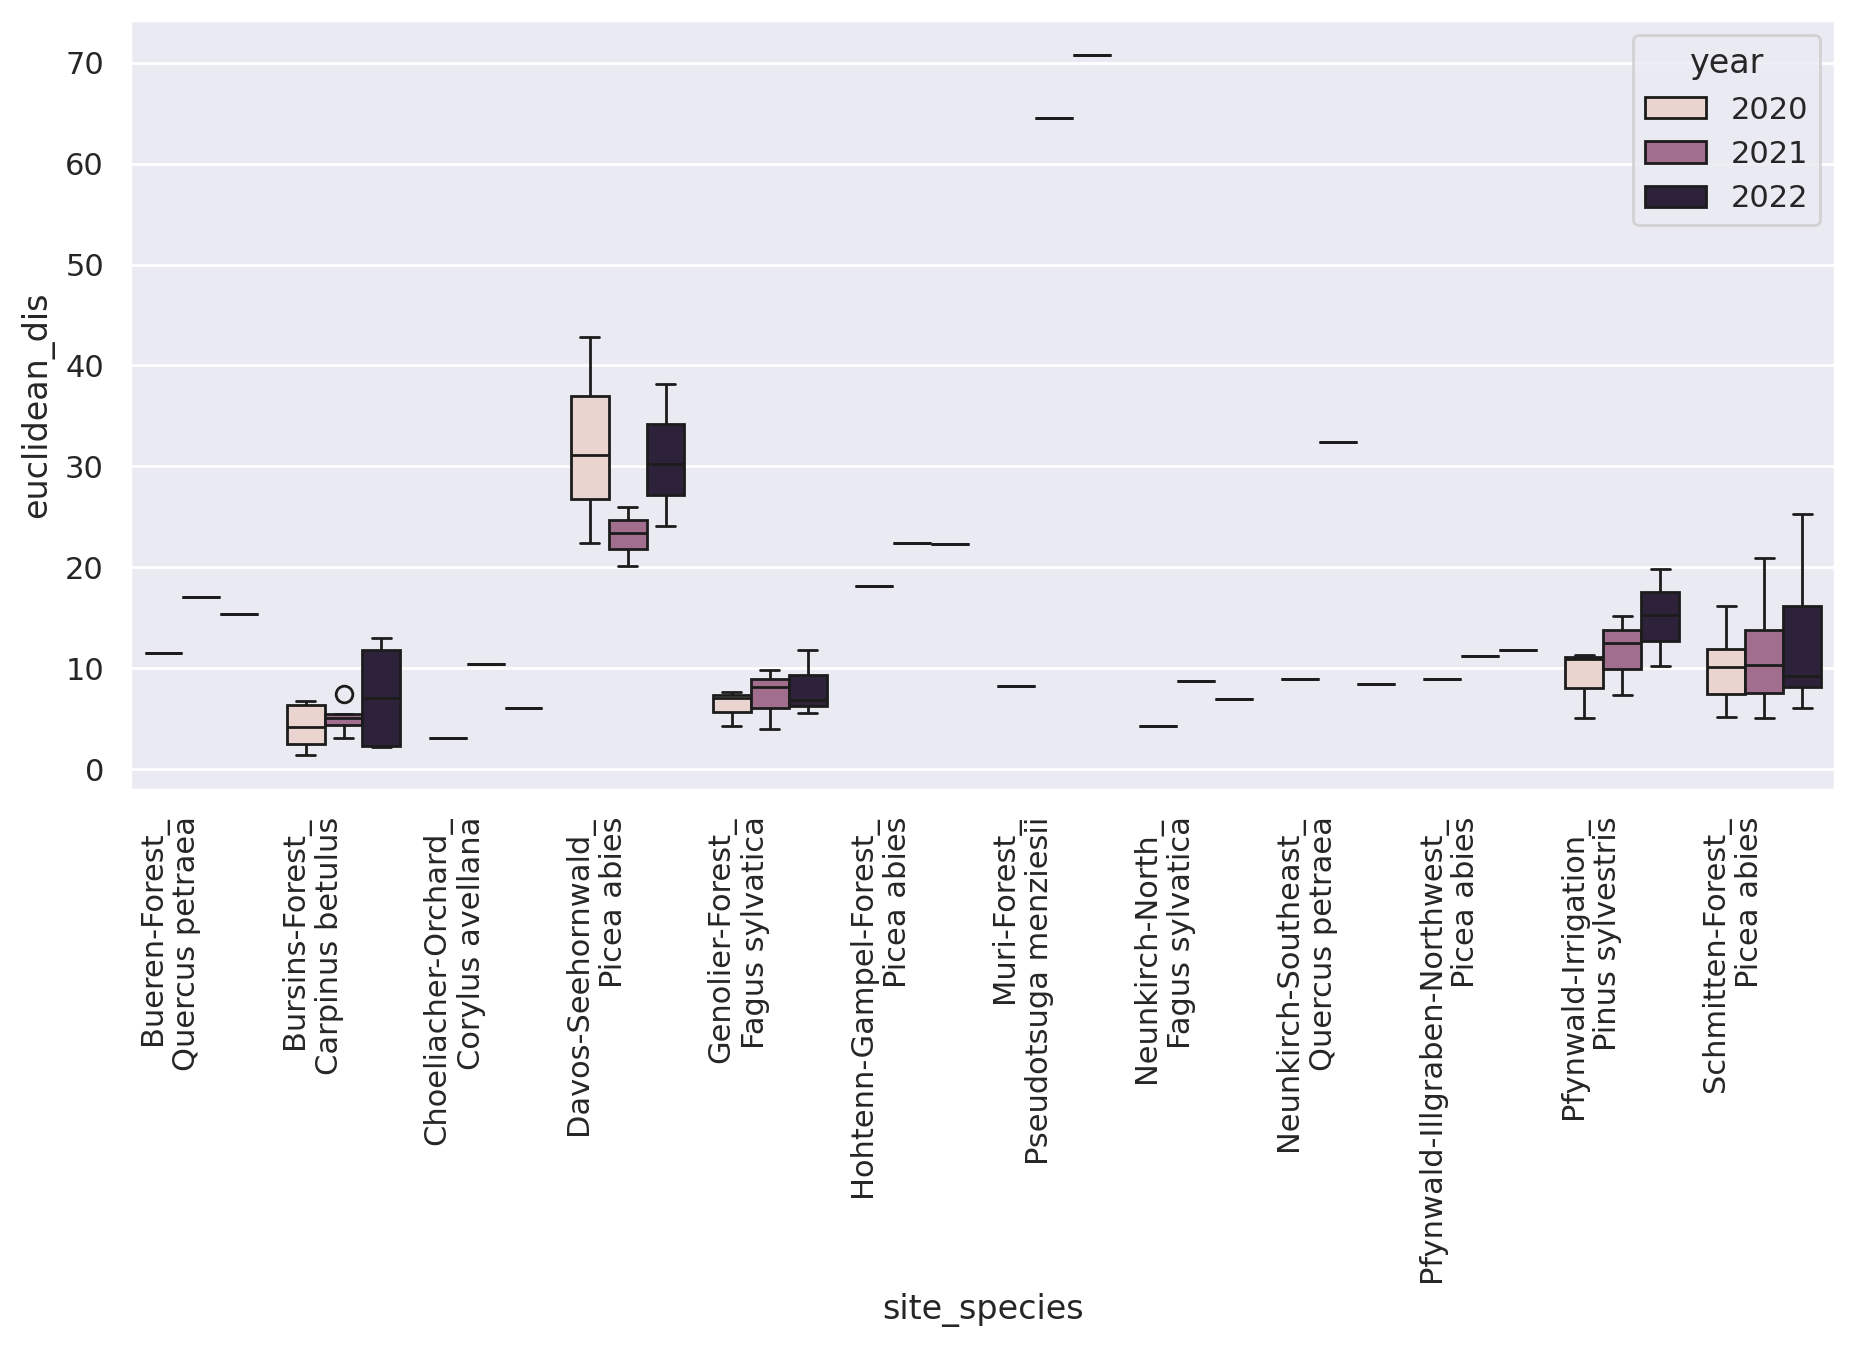

In [119]:
sns.set_theme(rc={'figure.figsize':(11,5),'figure.dpi': 200})
df_euc_all = pd.concat(df_list)
df_euc_all["site_species"] = df_euc_all["site_name"] + "_\n" + df_euc_all["species"]

ax = sns.boxplot(data=df_euc_all, x="site_species", y="euclidean_dis",
hue = "year")

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

In [38]:
fig = px.line(df_series_all, x='ts', y="Wt", color = "series", facet_row="site_name",
            facet_col = "year",
              symbol="species",
            #  
            facet_row_spacing = 0.01,
                # line_group = "species" 
                )

fig.update_traces(marker=dict(size=3))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) 
fig.update_layout(
    height=4000,
    width=800,
)

fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)

fig.show()

- Understand correlation? 
- compute PCA?
- read some paper about how to split the data? 
- auto-correlation?
- compute statistics? 
- how to use other variables? 

### calculate autocorrelation
- try for 2020

In [18]:
# Importing statsmodel dependencies

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_acf


In [19]:
df_series_all.loc[(df_series_all.series_no== 1) & (df_series_all.year == 2020), "twd"].autocorr(lag=3)

np.float64(0.6487688681585871)

In [20]:
n_lag = 50
acf_arrays= np.zeros(shape = (3, 42, n_lag+1))

for year_idx in range(0,3):
    for series_no in range(1,43):
        acf_arrays[year_idx, series_no-1, :] = acf(df_series_all.loc[(df_series_all.series_no== series_no) & (df_series_all.year == 2020+year_idx), "twd"], fft=False, nlags=n_lag)



df_auto_corr = pd.DataFrame(acf_arrays[0,:,:])
df_auto_corr['series_no'] = np.arange(1,43)
df_auto_corr_melt = df_auto_corr.melt(id_vars=['series_no'], var_name='lag', value_name='acf')
df_auto_corr_melt = df_auto_corr_melt.merge(twd_tree_series_sites[['series_no', 'site_name', 'species']], on='series_no', how='left')

In [21]:
mean_acf = pd.DataFrame(df_auto_corr_melt.groupby(['lag', 'site_name', "species"]).acf.mean()).reset_index()
mean_std = pd.DataFrame(df_auto_corr_melt.groupby(['lag', 'site_name', "species"]).acf.std()).reset_index()

mean_acf['std'] = mean_std['acf']
mean_acf = mean_acf.loc[mean_acf.acf!=0,]

In [22]:
mean_acf.loc[(mean_acf["species"] == "Fagus sylvatica") & (mean_acf["site_name"] == "Sihlwald-Forest") , ]
twd_tree_series_sites.loc[(twd_tree_series_sites["species"] == "Fagus sylvatica") & (twd_tree_series_sites["site_name"] == "Sihlwald-Forest") , ]

,series,species,site,series_no,site_name,site_longitude,site_latitude,site_easting,site_northing,mch_ind_closest,mch_easting,mch_northing,mch_elevation,mch_site_eucldist,species_site
41,1232,Fagus sylvatica,Sihlwald-Forest,42,Sihlwald-Forest,8.56111,47.25056,2.684971e+06,1.233901e+06,41819,2.684597e+06,1.233941e+06,722.265575,375.727303,Fagus sylvatica_Sihlwald-Forest


In [23]:
acf_arrays[2].mean(axis=0)

array([ 1.        ,  0.90847193,  0.80223451,  0.73220957,  0.68248435,
        0.63951693,  0.60014515,  0.56619588,  0.5381586 ,  0.51961556,
        0.50478401,  0.48560443,  0.46646387,  0.45060251,  0.43279265,
        0.4116492 ,  0.39015329,  0.36137946,  0.33966125,  0.33227707,
        0.32786008,  0.31702834,  0.30039694,  0.28364589,  0.26544666,
        0.2505225 ,  0.23755225,  0.22398713,  0.21111653,  0.18784038,
        0.1604333 ,  0.13587869,  0.11666431,  0.10098978,  0.08757571,
        0.07686682,  0.06480029,  0.05763106,  0.04943192,  0.04044096,
        0.0270572 ,  0.01616673,  0.00539739, -0.00470235, -0.0137422 ,
       -0.02764687, -0.04298822, -0.05773177, -0.07018686, -0.07749742,
       -0.08135897])

In [24]:
# acf_arrays.mean(axis =0)
# acf_arrays.std(axis =0)


# fig2 = px.line(y = acf_arrays[0].mean(axis =0), x= np.arange(n_lag+1),
# error_y = acf_arrays[0].std(axis =0), labels = "2020 mean")
fig2 = go.Figure()
fig2.add_trace(
    go.Scatter(
        x=np.arange(n_lag+1),
        y=acf_arrays[0].mean(axis=0),
        error_y=dict(array=acf_arrays[0].std(axis=0)),
        name='2020 Mean',
        line=dict(color='blue', width=2),
        showlegend=True
    )
)


# Add second line plot as a trace
fig2.add_trace(
    go.Scatter(
        x=np.arange(n_lag+1),
        y=acf_arrays[1].mean(axis=0),
        error_y=dict(array=acf_arrays[1].std(axis=0)),
        name='2021 Mean',
        line=dict(color='black', width=2),
        showlegend=True
    )
)

# Add third line plot as a trace
fig2.add_trace(
    go.Scatter(
        x=np.arange(n_lag+1),
        y=acf_arrays[2].mean(axis=0),
        error_y=dict(array=acf_arrays[2].std(axis=0)),
        name='2022 Mean',
        line=dict(color='red', width=2),
        showlegend=True
    )
)

fig2.show()





In [25]:
# Create first figure
fig = px.line(mean_acf, x="lag", y="acf",
              color="species", symbol="site_name",
              error_y="std", facet_row="species",
              )

# Add second line plot as a trace
fig.add_trace(
    go.Scatter(
        x=np.arange(n_lag+1),
        y=acf_arrays.mean(axis=0),
        error_y=dict(array=acf_arrays.std(axis=0)),
        name='Overall Mean',
        line=dict(color='black', width=2),
        showlegend=True
    )
)

fig.update_traces(opacity=.4)

# Update layout if needed
fig.update_layout(
    title='Autocorrelation Function by Species and Site',
    xaxis_title='Lag',
    yaxis_title='ACF',
    height = 2000, 
    width = 800,
    
)

fig.show()

n = 5 is good value for autocorrelation

#### compute correlation of the features with twd

In [39]:
corr = df_series_all[["twd", "pr", "at", "ws", "dp", "sr", "lr", "Wt"]].corr()

<Axes: >

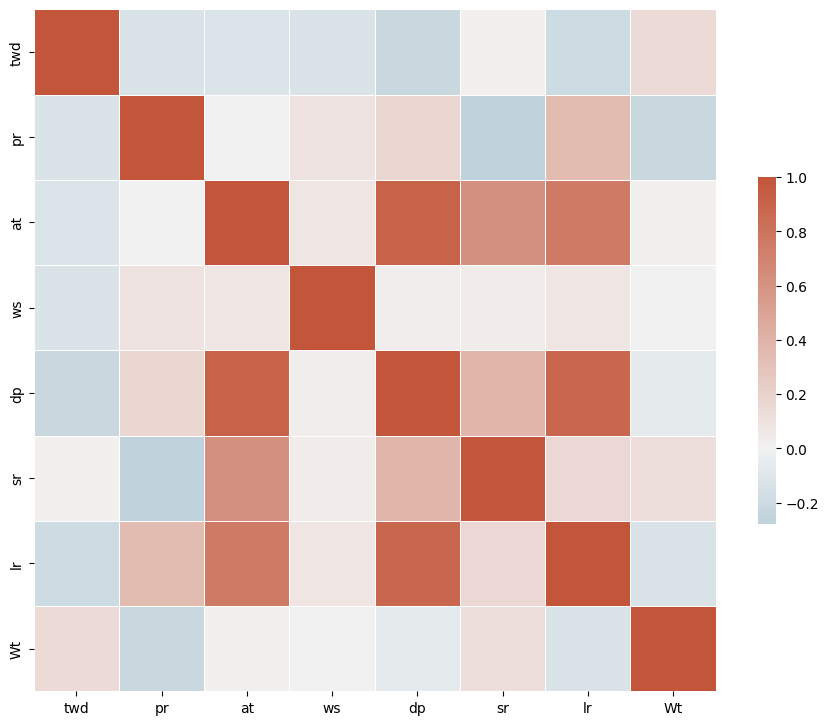

In [40]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap= cmap, vmax= 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## test a few models

start from simple model 
- understand the covariance, mean a little better
- gaussian process 

- random walk 
Yt = Yt-1 + Wt

- autoregressive

In [ ]:
# compute delta Yt-Yt-1
# Wt is clearly not Gaussian ...
df_series_all["Wt"] = df_series_all.

In [29]:
df_series_all.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
5,2020-01-06,0.000000,3.880511e-10,1.900865,1.479226,-5.472837,63.572741,220.306782,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
6,2020-01-07,0.593406,2.411429e-02,1.480216,2.514120,-1.105571,26.014536,265.315427,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
7,2020-01-08,0.557187,-6.457170e-07,3.140700,2.099829,-7.224881,48.464034,265.264362,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
8,2020-01-09,0.918142,-1.182159e-06,5.119999,1.631017,-5.251706,58.383674,248.506977,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
9,2020-01-10,1.269509,5.132516e-03,3.655803,3.022984,-0.587912,39.215077,289.792323,series_06,Bachtel-Forest,Fagus sylvatica,1,2020,1,2020-01
